
# 02 - Training Decision Transformer
Notebook de entrenamiento siguiendo la guía (opción 1).


In [1]:

%matplotlib inline
import sys, pathlib
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Ajustar path al root
ROOT = pathlib.Path.cwd()
if (ROOT / 'config_dataset.py').exists():
    sys.path.append(str(ROOT))
elif (ROOT.parent / 'config_dataset.py').exists():
    ROOT = ROOT.parent
    sys.path.append(str(ROOT))

from config_dataset import NUM_ITEMS
from src.data.load_data import load_training_data
from src.data.preprocessing import create_dt_dataset, validate_preprocessing
from src.data.dataset import RecommendationDataset
from src.models.decision_transformer import DecisionTransformer
from src.training.trainer import train_decision_transformer

print(f"NUM_ITEMS: {NUM_ITEMS}")
print(f"GPU disponible: {torch.cuda.is_available()}")


NUM_ITEMS: 472
GPU disponible: False



## Cargar datos procesados
Usa `data/processed/trajectories_train.pkl` si está disponible, sino procesa desde cero.


In [2]:

import pickle
from pathlib import Path

processed_path = Path('data/processed/trajectories_train.pkl')

if processed_path.exists():
    with processed_path.open('rb') as f:
        trajectories = pickle.load(f)
    print(f"Cargadas trayectorias desde {processed_path} -> {len(trajectories)}")
else:
    df_train = load_training_data()
    trajectories = create_dt_dataset(df_train)
    validate_preprocessing(trajectories)
    processed_path.parent.mkdir(parents=True, exist_ok=True)
    with processed_path.open('wb') as f:
        pickle.dump(trajectories, f)
    print(f"Generadas y guardadas trayectorias -> {len(trajectories)}")


Cargadas trayectorias desde data/processed/trajectories_train.pkl -> 16000



## Train/Val split y DataLoaders


In [3]:

context_length = 20
batch_size = 32
val_frac = 0.1

full_dataset = RecommendationDataset(trajectories, context_length=context_length)
val_size = int(len(full_dataset) * val_frac)
train_size = len(full_dataset) - val_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

print(f"Train size: {train_size}, Val size: {val_size}")
print(f"Batch size: {batch_size}")


Train size: 14400, Val size: 1600
Batch size: 32



## Instanciar modelo y optimizador


In [4]:

hidden_dim = 128
n_layers = 3
n_heads = 4
learning_rate = 1e-4
num_epochs = 5  # ajusta según recursos

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DecisionTransformer(
    num_items=NUM_ITEMS,
    num_groups=8,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    n_heads=n_heads,
    context_length=context_length,
)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



## Entrenamiento


In [5]:

model, history = train_decision_transformer(
    model,
    train_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    val_loader=val_loader,
)


Epoch 1/5 - train_loss=6.1593
  val_loss=6.1583
Epoch 2/5 - train_loss=6.1580
  val_loss=6.1581
Epoch 3/5 - train_loss=6.1580
  val_loss=6.1581
Epoch 4/5 - train_loss=6.1578
  val_loss=6.1578
Epoch 5/5 - train_loss=6.1576
  val_loss=6.1575



## Curva de loss


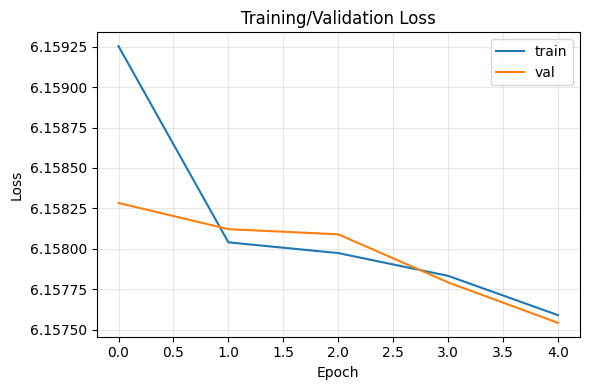

In [6]:

plt.figure(figsize=(6,4))
plt.plot(history['train_loss'], label='train')
if history['val_loss']:
    plt.plot(history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training/Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



## Guardar checkpoint


In [7]:

ckpt_path = Path('results/checkpoints/dt_checkpoint.pt')
ckpt_path.parent.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), ckpt_path)
print(f"Checkpoint guardado en {ckpt_path}")


Checkpoint guardado en results/checkpoints/dt_checkpoint.pt
